In [1]:
%load_ext jupyter_black

import random

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

from tqdm import tqdm

In [2]:
WIN_PTS = 25
LOSE_PTS = 25
PLAYERS_PER_TEAM = 5
RANDOM_SEED = 42
N_MATCHES = 1_200

In [3]:
random.seed(RANDOM_SEED)
np.random.seed(seed=RANDOM_SEED)

In [4]:
class Gamer:
    def __init__(
        self,
        skill: int,
        rating: int,
        wins: int = None,
        games: int = None,
        uid: int = None,
    ):
        self.skill_ = skill
        self.rating_ = rating
        self.wins_ = 0 if wins is None else wins
        self.games_ = 0 if games is None else games
        self.uid_ = 0 if uid is None else uid

    def get_skill(self) -> int:
        return self.skill_

    def get_rating(self) -> int:
        return self.rating_

    def get_uid(self) -> int:
        return self.uid_

    def win(self):
        self.rating_ += WIN_PTS
        self.wins_ += 1
        self.games_ += 1

    def lose(self):
        if self.rating_ > LOSE_PTS:
            self.rating_ -= LOSE_PTS
        self.games_ += 1

    def get_winrate(self) -> float:
        return self.wins_ / self.games_

In [5]:
class Matchmaker:
    def __init__(self, clutch_chance: float, random_seed: int = None):
        self.clutch_chance_ = clutch_chance
        if random_seed is not None:
            random.seed(random_seed)
            np.random.seed(seed=random_seed)

    def __call__(self, match: list[Gamer]):
        team1 = random.sample(match, PLAYERS_PER_TEAM)
        team2 = [player for player in match if player not in team1]
        teams = [team1, team2]

        skill_sums = [sum([player.get_skill() for player in team]) for team in teams]
        if skill_sums[0] > skill_sums[1]:
            winning_team = 0
        elif skill_sums[1] > skill_sums[0]:
            winning_team = 1
        else:
            winning_team = np.random.randint(0, 1)

        is_clutch = np.random.choice(
            [0, 1], size=None, p=[1.0 - self.clutch_chance_, self.clutch_chance_]
        )
        if is_clutch == 1:
            winning_team = 1 - winning_team

        for player in teams[winning_team]:
            player.win()

        for player in teams[1 - winning_team]:
            player.lose()

In [6]:
class Community:
    def __init__(self, n_gamers: int):
        if n_gamers % (PLAYERS_PER_TEAM * 2) != 0:
            raise ValueError(
                f"Number of gamers is not divisible by {PLAYERS_PER_TEAM*2}!"
            )

        self.match_size_ = PLAYERS_PER_TEAM * 2
        self.n_gamers_ = n_gamers
        skill_distr = sp.stats.betabinom(1000, 4.243, 4.217)
        self.gamers = [
            Gamer(skill=gamer_skill, rating=500, uid=uid)
            for uid, gamer_skill in enumerate(skill_distr.rvs(size=n_gamers))
        ]
        random.shuffle(self.gamers)
        self.matchmaker = Matchmaker(1e-2)

    def rank_gamers(self):
        self.gamers.sort(key=lambda x: x.get_rating())

    def get_gamers(self):
        return self.gamers

    def match(self, steps: int):
        for i in tqdm(range(steps)):
            self.rank_gamers()
            for match_num in range(self.n_gamers_ // self.match_size_):
                self.matchmaker(
                    self.gamers[
                        self.match_size_
                        * match_num : self.match_size_
                        * (match_num + 1)
                    ]
                )

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1200/1200 [01:34<00:00, 12.64it/s]


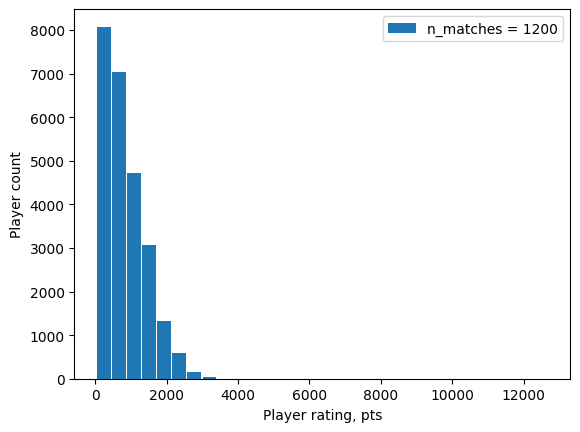

In [7]:
cmty = Community(25_000)

cmty.match(N_MATCHES)

gamers = cmty.get_gamers()
ratings = np.array([player.get_rating() for player in gamers])

ax = plt.axes()

ax.hist(ratings, rwidth=0.9, bins=30, label=f"n_matches = {N_MATCHES}")
ax.set_xlabel("Player rating, pts")
ax.set_ylabel("Player count")
plt.legend()
plt.show()

In [8]:
print(f"Top-10 rating values: {ratings[-10:]}")

Top-10 rating values: [ 3200  3250  3250  3250  3350  3500  4550  6950 12100 12700]


In [9]:
print(f"Rating mode: {sp.stats.mode(ratings)}")

Rating mode: ModeResult(mode=np.int64(600), count=np.int64(574))


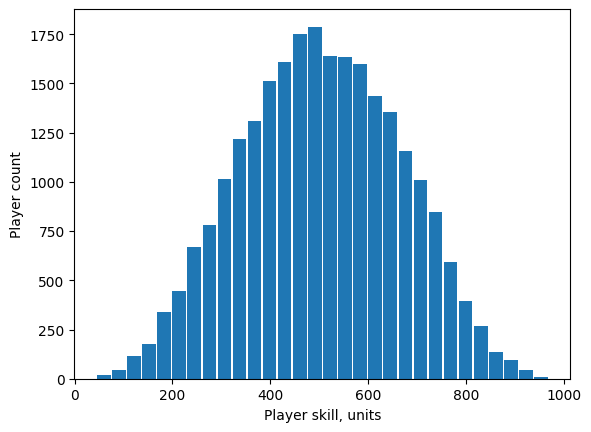

In [10]:
gamers = cmty.get_gamers()
skill_ratings = np.array([player.get_skill() for player in gamers])

ax = plt.axes()

ax.hist(skill_ratings, rwidth=0.9, bins=30)
ax.set_xlabel("Player skill, units")
ax.set_ylabel("Player count")
plt.show()

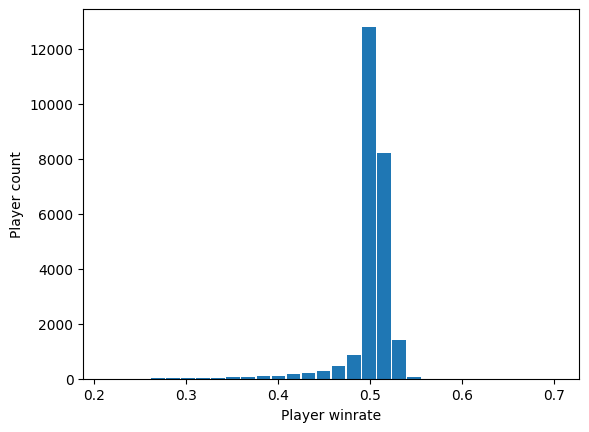

In [11]:
gamers = cmty.get_gamers()
winrates = np.array([player.get_winrate() for player in gamers])

ax = plt.axes()

ax.hist(winrates, rwidth=0.9, bins=30)
ax.set_xlabel("Player winrate")
ax.set_ylabel("Player count")
plt.show()

In [12]:
sum([1 for wr in winrates if wr < 0.5])

9093

In [13]:
sum([1 for wr in winrates if wr > 0.5])

15048

In [14]:
[
    (
        sp.ndimage.median(
            [
                player.get_skill()
                for player in gamers
                if player.get_rating() >= i * 500
                and player.get_rating() < (i + 1) * 500
            ]
        ),
        i * 500,
        (i + 1) * 500,
    )
    for i in range(8)
]

[(np.float64(344.0), 0, 500),
 (np.float64(515.0), 500, 1000),
 (np.float64(628.0), 1000, 1500),
 (np.float64(724.0), 1500, 2000),
 (np.float64(801.0), 2000, 2500),
 (np.float64(875.0), 2500, 3000),
 (np.float64(922.5), 3000, 3500),
 (np.float64(949.0), 3500, 4000)]